In [1]:
# Python imports
import sys

# PyTorch imports
import torch
import torchvision

# Third-party imports
import matplotlib.pyplot as plt

# Own imports
import utils

# 0. Constants

In [2]:
BATCH_SIZE = 10
LEARNING_RATE = 0.001
EPOCHS = 10
WIDTH, HEIGHT = 28, 28

# 1. Dataset

In [3]:
dataset_training = torchvision.datasets.MNIST('./data', download=True, train=True, transform=torchvision.transforms.ToTensor())
dataset_test = torchvision.datasets.MNIST('./data', download=True, train=False, transform=torchvision.transforms.ToTensor())

In [4]:
dataloader_training = torch.utils.data.DataLoader(dataset_training, batch_size=BATCH_SIZE, shuffle=True)
dataloader_test = torch.utils.data.DataLoader(dataset_test, batch_size=BATCH_SIZE, shuffle=True)

## 1.1. Dataset Properties

### 1.1.1. Length of Datasets

In [5]:
print(f'Length of training dataset: {len(dataset_training)}')
print(f'Length of test dataset: {len(dataset_test)}')

Length of training dataset: 60000
Length of test dataset: 10000


### 1.1.2. Value Range

In [6]:
image, _ = dataset_training[0]
print(f'Min value of images is {image.min()}')
print(f'Max value of images is {image.max()}')

Min value of images is 0.0
Max value of images is 1.0


### 1.1.3. Sample Plots

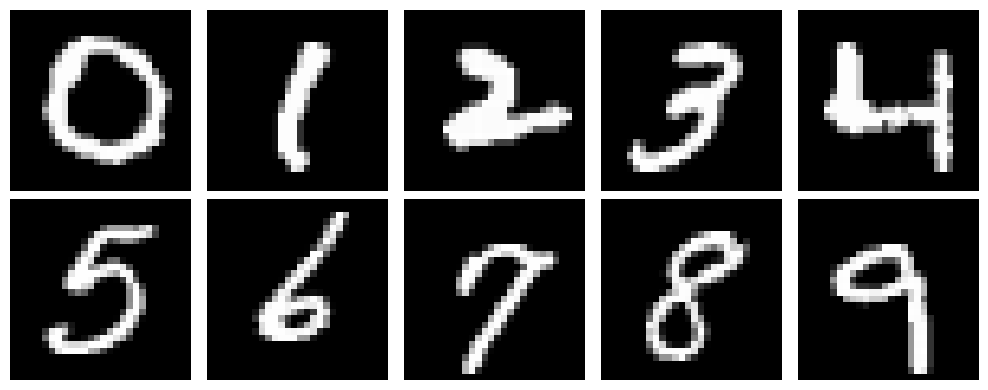

In [7]:
# Sample 10 images with labels 0 to 9.
samples = utils.sample_MNIST_with_all_labels(dataset_training)

# Plot the images.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
plt.tight_layout()

# 2. Model

In [8]:
model = torch.nn.Sequential(
    torch.nn.Flatten(),
    torch.nn.Linear(28*28, 10),
    torch.nn.Softmax(dim=1)
)
print(model)

Sequential(
  (0): Flatten(start_dim=1, end_dim=-1)
  (1): Linear(in_features=784, out_features=10, bias=True)
  (2): Softmax(dim=1)
)


# 3. Train

In [9]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), LEARNING_RATE)

# Run epochs.
losses, corrects = [], []
losses_test, corrects_test = [], []
for epoch in range(EPOCHS):

    # Run one epoch for training.
    num_batches = len(dataloader_training)
    num_samples = len(dataloader_training.dataset)
    loss_epoch, correct_epoch = 0, 0
    for batch, [images, labels] in enumerate(dataloader_training):
        # Make predictions.
        pred = model(images)

        # Calculate the loss.
        loss = loss_fn(pred, labels)
        loss_epoch += loss.item()

        # Calculate the number of correctness.
        correct_epoch += (pred.argmax(dim=1) == labels).type(dtype=torch.float32).sum().item()

        # Back propagation.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (batch + 1) % 1000 == 0:
            loss, size_current, size_total = loss.item(), (batch+1)*BATCH_SIZE, len(dataloader_training.dataset)
            print(f'loss: {loss:>7f} [{size_current:>5d} / {size_total:>5d}]')
        
    # Calculate the mean loss across all batches.
    loss_epoch /= num_batches
    losses.append(loss_epoch)

    # Calculate the mean number of correctness across all batches.
    correct_epoch /= num_samples
    corrects.append(correct_epoch)

    # Print statistics of the training part of the epoch.
    print(f'Training error: loss: {loss_epoch:>7f}, accuracy: {correct_epoch*100:>0.1f}%')

    # Run one epoch for test.
    loss_test, correct_test = 0, 0
    num_batches_test = len(dataloader_test)
    num_samples_test = len(dataloader_test.dataset)
    with torch.no_grad():
        for images, labels in dataloader_test:
            # Make predictions.
            pred = model(images)

            # Calculate the loss.
            loss_test += loss_fn(pred, labels).item()

            # Calculate the number of correctness.
            correct_test += (pred.argmax(dim=1) == labels).type(torch.float32).sum().item()
    
    # Calculate the mean loss across all batches.
    loss_test /= num_batches_test
    losses_test.append(loss_test)

    # Calculate the mean number of correctness across all batches.
    correct_test /= num_samples_test
    corrects_test.append(correct_test)

    # Print statistics of the test part of the epoch.
    print(f'Test error: loss: {loss_test:>7f}, accuracy: {correct_test*100:>0.1f}%')


loss: 2.281273 [10000 / 60000]
loss: 2.289013 [20000 / 60000]
loss: 2.261842 [30000 / 60000]
loss: 2.237354 [40000 / 60000]
loss: 2.096594 [50000 / 60000]
loss: 2.172271 [60000 / 60000]
Training error: loss: 2.235190, accuracy: 41.8%
Test error: loss: 2.147221, accuracy: 55.1%
loss: 2.223168 [10000 / 60000]
loss: 2.084541 [20000 / 60000]
loss: 1.984540 [30000 / 60000]
loss: 2.120323 [40000 / 60000]
loss: 1.874057 [50000 / 60000]
loss: 2.105985 [60000 / 60000]
Training error: loss: 2.060507, accuracy: 59.2%
Test error: loss: 1.981398, accuracy: 62.8%
loss: 2.023103 [10000 / 60000]
loss: 2.044066 [20000 / 60000]
loss: 2.013910 [30000 / 60000]
loss: 1.970258 [40000 / 60000]
loss: 1.899578 [50000 / 60000]
loss: 1.946286 [60000 / 60000]
Training error: loss: 1.947293, accuracy: 63.0%
Test error: loss: 1.906748, accuracy: 65.6%
loss: 1.876288 [10000 / 60000]
loss: 1.553415 [20000 / 60000]
loss: 1.893914 [30000 / 60000]
loss: 1.918868 [40000 / 60000]
loss: 1.619849 [50000 / 60000]
loss: 1.926

## 3.1. Visualization of the training process

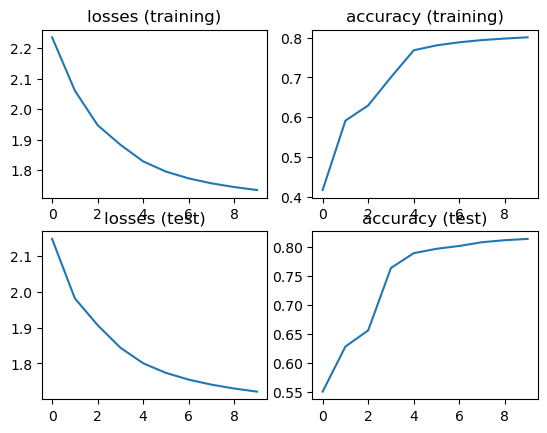

In [16]:
fig, ((ax11, ax12), (ax21, ax22)) = plt.subplots(2,2)

ax11.plot(losses)
ax11.set_title('losses (training)')
ax12.plot(corrects)
ax12.set_title('accuracy (training)')
ax21.plot(losses_test)
ax21.set_title('losses (test)')
ax22.plot(corrects_test)
ax22.set_title('accuracy (test)')

plt.show()

# 4. Use

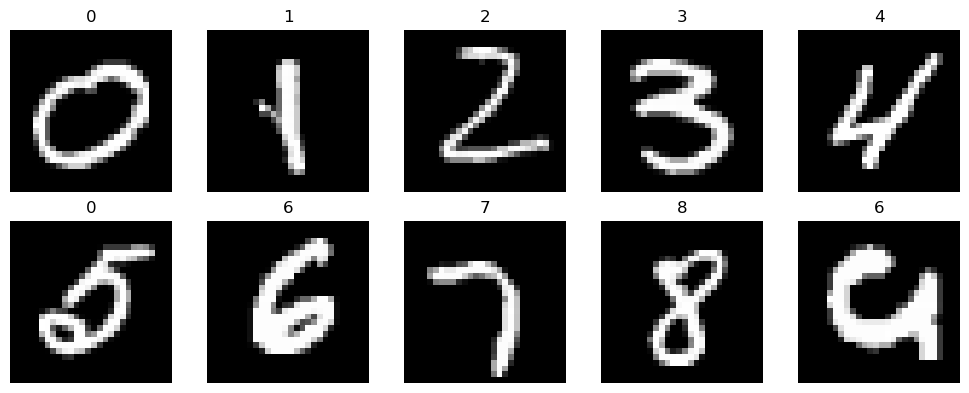

In [24]:
# Sample 10 images with labels 0 to 9 from the test dataset.
samples = utils.sample_MNIST_with_all_labels(dataset_test)

preds = {}
for label, image in samples.items():
    pred = model(image)
    preds[label] = pred.argmax(dim=1)[0].item()

# Plot the images with labels.
rows, cols = 2, 5
plt.figure(figsize=(10, 4))
for i in range(rows * cols):
    plt.subplot(rows, cols, i+1)
    plt.axis('off')
    plt.imshow(samples[i].squeeze(), cmap=plt.cm.gray)
    plt.title(preds[i])
plt.tight_layout()